## Coding Challenge for Fracta

成田博行　2022年6月13日　

#### Task 1 を選択 

- 2021年におけるパイプの破損率を予測するモデルを構築する
- モデルの評価指標を作成し、それに基づいてモデルを評価する

#### 結論

以下にモデルを作成し、2021年における破損率は2.8%と予測する。

作成した評価指標によって、複数のモデルから精度のより高いものを選択した。

lightGBMとXGBoostによって、それぞれモデルA、モデルBを作成。

- 2021年における破損率
    * モデルA: 2.7%
    * モデルB: 3.0%

- 作成した評価指標
    * モデルA: 6.1%
    * モデルB: 5.8%

作成した評価指標を比較するとモデルBの方が精度が高く、その場合2021年における破損率は3.0%である。

In [2]:
!pip3 install Japanize-matplotlib

In [3]:
import pandas as pd
import numpy as np
import joblib
import sys, os
import dateutil
from datetime import datetime, timedelta
from glob import glob
import matplotlib.pyplot as plt
import japanize_matplotlib
sys.path.append('../..')
from utils import *

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
df_pipe = pd.read_csv('./fracta_Dec3.csv')
df_wk = df_pipe.copy()
display(df_wk.head())

,pipe_id,install_year,material,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,...,env_dat_135,env_dat_136,env_dat_137,env_dat_138,env_dat_139,env_dat_140,env_dat_141,env_dat_142,env_dat_143,env_dat_144
0,P0000000000,1985,D,20.32,NaN,623.542175,18.052843,14.161422,10.268579,159.662827,...,554.479675,20.000000,0.000038,438.628143,27.000000,3085.786865,0.002728,0.311803,0.0,0.0
1,P0000000001,1934,C,15.24,NaN,644.830017,17.790001,13.830000,9.870000,257.001221,...,276.357605,9.200573,0.304329,239.719299,32.571018,3188.292236,0.003291,0.322161,0.0,0.0
2,P0000000002,1904,C,20.32,NaN,604.570007,18.219999,14.350000,10.470000,225.165039,...,236.882950,4.872639,0.182168,500.638367,28.978306,4542.257324,0.002928,0.458972,0.0,0.0
3,P0000000003,1979,D,15.24,NaN,573.424011,17.671381,14.132636,10.586646,170.244339,...,321.886658,12.353504,0.480517,295.554504,41.983772,4521.720215,0.004242,0.456897,0.0,0.0
4,P0000000004,1987,D,20.32,NaN,583.429993,18.280001,14.350000,10.420000,171.034073,...,758.841431,25.052542,0.021532,778.687256,25.842377,4978.718262,0.002611,0.503074,0.0,0.0


### EDA(Exploratory Data Analysis)
- 全体で56774件のレコードが存在し、そのうち故障件数は3144
- およそ5.5%程に故障年が存在する

In [5]:
total = len(df_wk)
death = len(df_wk[df_wk['break_year'].notna()])
birth = len(df_wk['install_year'].notna())

display(total)
display(death)
display(death/total)

56774

3144

0.05537746151407334

material のカラムはカテゴリ変数であるため、ダミー変数（One-Hotエンコーディング）を生成する 

In [6]:
df_wk = pd.get_dummies(df_wk, columns=['material'])

故障年が既知のデータにつきEDAを進めていきます

In [7]:
df_break=df_wk[df_wk['break_year'].notna()].copy()
df_break.head()

,pipe_id,install_year,diameter,break_year,env_dat_0,env_dat_1,env_dat_2,env_dat_3,env_dat_4,env_dat_5,...,env_dat_140,env_dat_141,env_dat_142,env_dat_143,env_dat_144,material_A,material_C,material_D,material_O,material_S
41,P0000000041,1983,20.32,1990.0,568.710022,17.559999,14.100000,10.640000,0.023671,0.000005,...,3799.932617,0.000505,0.383964,0.0,0.0,0,0,1,0,0
52,P0000000052,1968,20.32,1995.0,580.960022,18.260000,14.340000,10.420000,299.776337,0.037117,...,4485.814941,0.001921,0.453269,0.0,1.0,0,0,1,0,0
63,P0000000063,1991,10.16,2003.0,615.322571,18.112228,14.210916,10.309492,105.444649,0.010701,...,3073.178467,0.002991,0.310529,0.0,0.0,0,0,1,0,0
68,P0000000068,1924,20.32,2015.0,610.489990,17.080000,13.870000,10.650000,113.146187,0.007912,...,5311.120117,0.002717,0.536662,0.0,0.0,0,1,0,0,0
87,P0000000087,1947,15.24,1995.0,644.830017,17.790001,13.830000,9.870000,86.456589,0.006315,...,3178.726807,0.002754,0.321194,0.0,0.0,0,1,0,0,0


故障したものについて年齢を算出し、ヒストグラムをプロットする

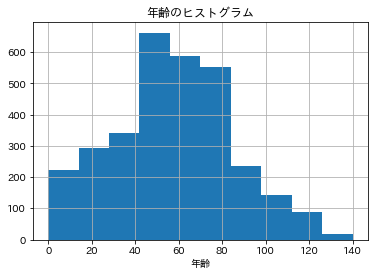

In [8]:
df_break['age'] = df_break['break_year'] - df_break['install_year']
df_break['age'].hist()
plt.title('年齢のヒストグラム')
plt.xlabel('年齢')
plt.show()

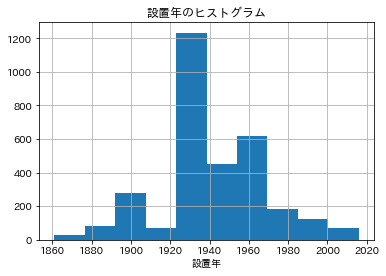

In [9]:
df_break['install_year'].hist()
plt.title('設置年のヒストグラム')
plt.xlabel('設置年')
plt.show()

故障年は1980年から2016年までです

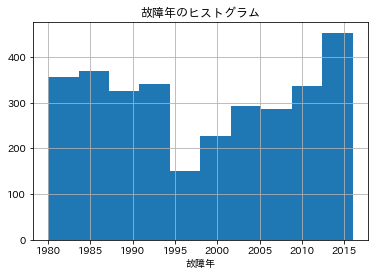

In [10]:
df_break['break_year'].hist()
plt.title('故障年のヒストグラム')
plt.xlabel('故障年')
plt.show()

1980年以前と以降に破損データに差異が認められる。

1861年から2017年のデータが存在する。

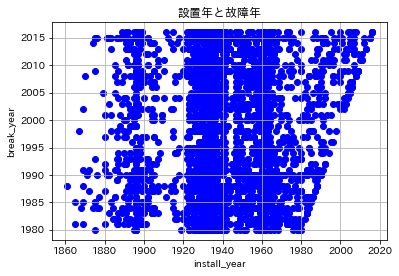

In [11]:
plt.scatter(df_break['install_year'], df_break['break_year'], color = 'blue') 

plt.title('設置年と故障年')
plt.xlabel('install_year')
plt.ylabel('break_year')
plt.grid()

plt.show()   

どの設置年をとっても、年齢には約40年程の巾が認められる

1890年以前、1910年から1920年等を除いて、40年間ほぼ一様にデータが存在する事が分かる

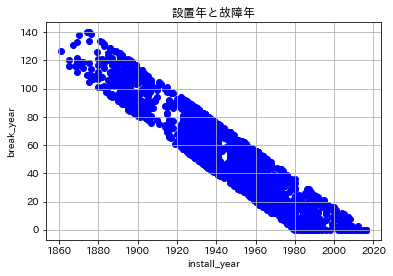

In [12]:
plt.scatter(df_break['install_year'], df_break['age'], color = 'blue') 

plt.title('設置年と故障年')
plt.xlabel('install_year')
plt.ylabel('break_year')
plt.grid()

plt.show() 

パイプの設置年毎にその年齢（故障までの年数）を可視化する

1980年までは設置年と年齢を足すとおよそ1980である

1980年から平均は変化している

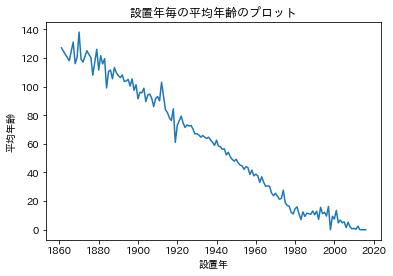

In [13]:
df_stats = df_break.set_index('install_year')
df_stats = df_stats.groupby('install_year').mean()
plt.plot(df_stats['age'])
plt.title('設置年毎の平均年齢のプロット')
plt.xlabel('設置年')
plt.ylabel('平均年齢')
plt.show()

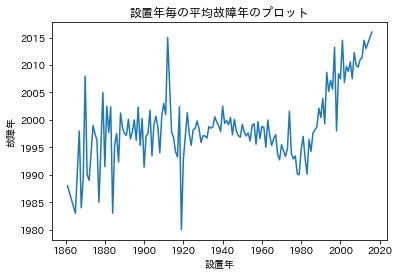

In [14]:
plt.plot(df_stats['break_year'])
plt.title('設置年毎の平均故障年のプロット')
plt.xlabel('設置年')
plt.ylabel('故障年')
plt.show()

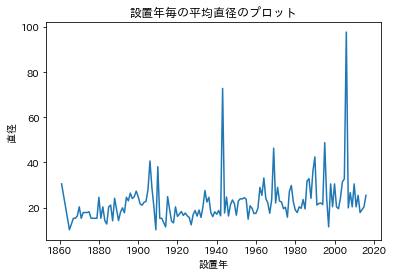

In [15]:
plt.plot(df_stats['diameter'])
plt.title('設置年毎の平均直径のプロット')
plt.xlabel('設置年')
plt.ylabel('直径')
plt.show()

故障年が分かっていないデータについて年数を算出する

53636件のデータが存在する

53630

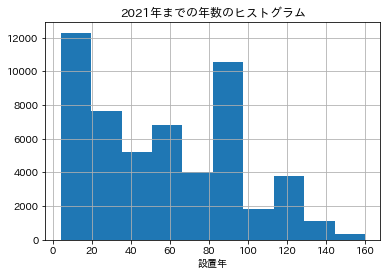

In [16]:
df_alive=df_wk[df_wk['break_year'].isna()]
# df_break['break_year'].hist()

df_alive['age'] = 2021 - df_alive['install_year']
display(len(df_alive))
df_alive['age'].hist()
plt.title('2021年までの年数のヒストグラム')
plt.xlabel('設置年')
plt.show()

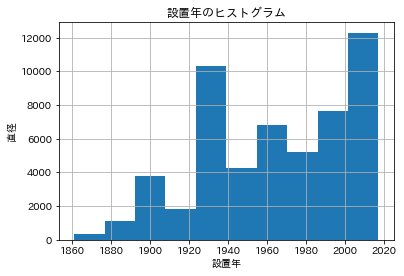

In [17]:
df_alive['install_year'].hist()
plt.title('設置年のヒストグラム')
plt.xlabel('設置年')
plt.ylabel('直径')
plt.show()

In [18]:
# import math
# def draw_graph(df_product):
#     cols = 5
#     nums = 145
#     rows = math.ceil(nums / cols)
#     fig = plt.figure(facecolor='white', figsize=(10 * cols, 10 * rows))
    
#     # for i, (name, code) in enumerate(zip(df_product['製品名'], df_product['製品コード'])):
#     for i in range(nums):
#         ax = fig.add_subplot(rows, cols, i + 1)
#         label = 'env_dat_'+str(i)
#         df = df_product[label]
#         ax.hist(df)
#         plt.xticks(rotation=90)
#         ax.set_title(f'{label}')
#         ax.set_ylabel(f'{label}')
#         # ax.set_xlabel('受注月')
#     fig.tight_layout()
#     fig.show()
#     fig.savefig(f'{label}.png')

In [19]:
# draw_graph(df_break)

<AxesSubplot:>

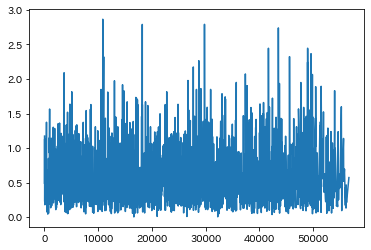

In [20]:
df_break['env_dat_66'].plot()

### 特徴量エンジニアリング

- age をbreak_year - install_year から生成
- age を追加し、install_year, break_year は消去


In [21]:
X = df_break.drop(['age', 'pipe_id','break_year'], axis=1)
y = df_break['age']
A_install_year = df_alive['install_year']

強い相関のある特徴量を取り除く

In [22]:
from sklearn import covariance

# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
# X.drop(to_drop, axis=1, inplace=True)

# len(to_drop)
# display(to_drop)

In [23]:
drop_list = [
    # 'env_dat_31',
    # 'env_dat_40',
    # 'env_dat_48',
    # 'env_dat_80',
    # 'env_dat_99',
    # 'env_dat_123',
    # 'env_dat_126',
    # 'env_dat_127',
    # 'env_dat_27',
    # 'env_dat_45',
    # 'env_dat_49',
    # 'env_dat_51',
    # 'env_dat_77',    
    # 'env_dat_78',
    # 'env_dat_124',
    # 'env_dat_36',
    # 'env_dat_130', 
    # 'env_dat_55',
    # 'env_dat_118',
    # 'env_dat_35',
    # 'env_dat_76',
    # 'env_dat_28',
    # 'env_dat_52',
    # 'env_dat_56',
    # 'env_dat_125',
    # 'env_dat_75',
    # 'env_dat_79',
    # 'env_dat_128',
    # 'env_dat_46',
    # 'env_dat_37', 
    # 'env_dat_44', 
    # 'env_dat_58', 
    # 'env_dat_33', 
    # 'env_dat_43', 
    # 'env_dat_47', 
    # 'env_dat_50', 
    # 'env_dat_96', 
    # 'env_dat_84', 
    # 'env_dat_17', 
    # 'env_dat_90', 
    # 'env_dat_30', 
    # 'env_dat_83', 
    # 'env_dat_42', 
    # 'env_dat_53', 
    # 'env_dat_117', 
    # 'env_dat_91', 
    # 'env_dat_143', 
    # 'env_dat_85', 
    # 'env_dat_81', 
    # 'env_dat_100',  
    # 'env_dat_100',    
    'age', 
    'pipe_id',
    'break_year',
    'install_year',
    ]

X = df_break.drop(drop_list, axis=1).drop(to_drop, axis=1)
A = df_alive.drop(drop_list, axis=1).drop(to_drop, axis=1)

訓練データと確認データを生成

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### lightGBMを使用したモデル構築（モデルA）

予測については、設置年と破損年から年齢を算出し、年齢を予測する事とする
- EDAの結果から、訓練データの設置年の1980年においてデータの傾向に変化が観察されるため、設置年に影響されないような工夫が必要となる

予測精度向上
1. Optunaを使用しハイパーパラメータを最適化
1. 最適化されたパラメータに基づき、パラメータを設定
1. 特徴量の重要度の低いものは特徴量から外す
1. 特徴量の強い相関のあるものは外す
1. 試行毎に評価指標を比較する

以上の作業を繰り返す

In [62]:
%%time
# import optuna.integration.lightgbm as lgb # optuna使用の場合
import lightgbm as lgb
from lightgbm import Dataset

# LightGBM用のデータセットに変換
train = Dataset(X_train, y_train)
val = Dataset(X_test, y_test)

# ハイパーパラメータサーチの設定
params = {
        'objective': 'regression',
        'metric': 'rmse',
        'random_seed': 0,
        'feature_pre_filter': False,
        'lambda_l1': 1.2934310141263734e-08,
        'lambda_l2': 0.00024010812891520896,
        'num_leaves': 300,
        'feature_fraction': 0.7799999999999999,
        'bagging_fraction': 0.7968312928847705,
        'bagging_freq': 6,
        'min_data_in_leaf': 5,
        'min_child_samples': 5,
        'num_iterations': 1000,
        'early_stopping_round': 3000    
}

gbm = lgb.train(params,
                    train,
                    valid_sets=val,
                    early_stopping_rounds=3000,
                    verbose_eval=20000)

# ベストパラメータの取得
best_params = gbm.params
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10182
[LightGBM] [Info] Number of data points in the train set: 2106, number of used features: 70
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=5 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Info] Start training from score 56.705128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 3000 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

学習したモデルで推論する

In [63]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

全ての評価指標を計算、表示する

In [27]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標をまとめた結果

    """
    scores = {}
    scores = pd.DataFrame({'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores

scores = calculate_scores(y_test, y_pred_test)
display(scores)

,R2,MAE,MSE,RMSE
scores,0.560285,14.375951,350.041735,18.709402


特徴量の重要度の可視化

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

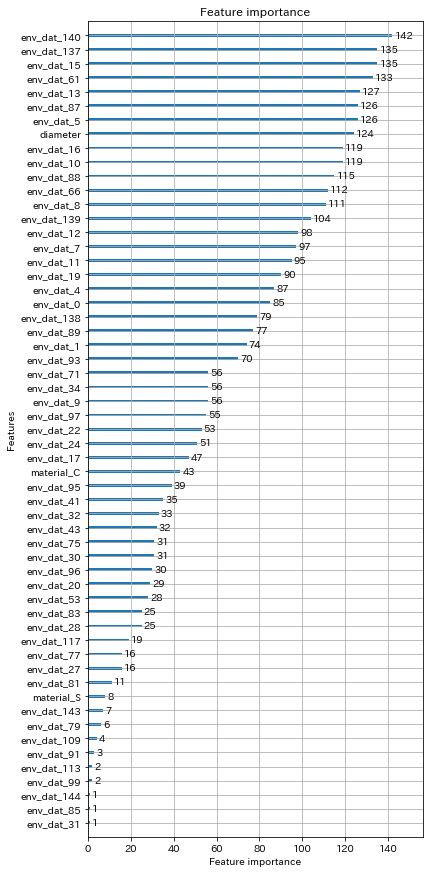

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

lgb.plot_importance(gbm, figsize=(6, 15))

訓練データのバックテスト

2106

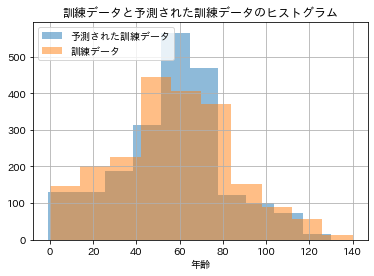

In [29]:
display(len(y_pred_train))

plt.hist(y_pred_train, alpha=0.5, label='予測された訓練データ')
plt.hist(y_train, alpha=0.5, label='訓練データ')
plt.title('訓練データと予測された訓練データのヒストグラム')
plt.xlabel('年齢')
plt.grid()
plt.legend(loc='upper left')
plt.show() 

年齢の実測値と予測値の関係を可視化する

上の評価指標で数値化されている

学習は出来ているが、精度向上の余地はあるように思われる
 
- R2の値が約0.5台であるため 

2106

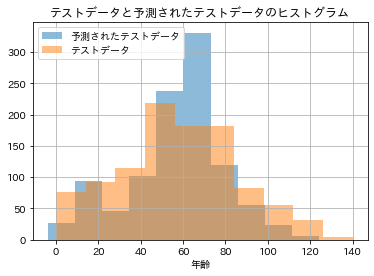

In [30]:
display(len(y_pred_train))

plt.hist(y_pred_test, alpha=0.5, label='予測されたテストデータ')
plt.hist(y_test, alpha=0.5, label='テストデータ')
plt.title('テストデータと予測されたテストデータのヒストグラム')
plt.xlabel('年齢')
plt.grid()
plt.legend(loc='upper left')
plt.show() 

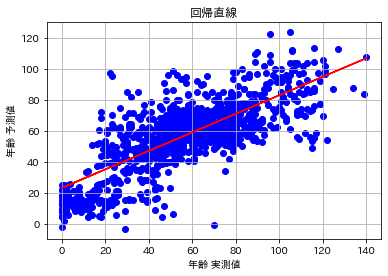

In [31]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

y_list_test = y_test.to_numpy()
lr.fit(y_list_test.reshape(-1, 1), y_pred_test)

plt.scatter(y_list_test, y_pred_test, color = 'blue')         # 説明変数と目的変数のデータ点の散布図をプロット
plt.plot(y_list_test, lr.predict(y_list_test.reshape(-1, 1)), color = 'red') # 回帰直線をプロット

plt.title('回帰直線')
plt.xlabel('年齢 実測値')
plt.ylabel('年齢 予測値')
plt.grid()

plt.show()          

### 破損年にデータのないものについて寿命（残存年数）を予測する

In [32]:
A

,diameter,env_dat_0,env_dat_1,env_dat_4,env_dat_5,env_dat_7,env_dat_8,env_dat_9,env_dat_10,env_dat_11,...,env_dat_137,env_dat_138,env_dat_139,env_dat_140,env_dat_143,env_dat_144,material_A,material_C,material_O,material_S
0,20.32,623.542175,18.052843,159.662827,0.010340,0.000000,0.014131,0.030000,0.005549,0.018021,...,0.000038,438.628143,27.000000,3085.786865,0.0,0.0,0,0,0,0
1,15.24,644.830017,17.790001,257.001221,0.007786,0.002000,0.020461,0.030000,0.002834,0.019916,...,0.304329,239.719299,32.571018,3188.292236,0.0,0.0,0,1,0,0
2,20.32,604.570007,18.219999,225.165039,0.014548,0.002439,0.019730,0.030000,0.025404,0.024890,...,0.182168,500.638367,28.978306,4542.257324,0.0,0.0,0,1,0,0
3,15.24,573.424011,17.671381,170.244339,0.014938,0.000583,0.013436,0.024051,0.009103,0.009103,...,0.480517,295.554504,41.983772,4521.720215,0.0,0.0,0,0,0,0
4,20.32,583.429993,18.280001,171.034073,0.025906,0.000000,0.013436,0.022966,0.009131,0.009131,...,0.021532,778.687256,25.842377,4978.718262,0.0,0.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56769,20.32,610.280029,18.280001,190.049469,0.010628,0.001782,0.015962,0.029971,0.002218,0.005431,...,0.719997,170.973465,26.000000,2504.886719,0.0,0.0,0,0,0,0
56770,20.32,610.280029,18.280001,190.049469,0.010628,0.001782,0.015962,0.029971,0.002218,0.005431,...,0.719997,170.973465,26.000000,2504.886719,0.0,0.0,0,0,0,0
56771,20.32,610.280029,18.280001,190.049469,0.010628,0.001782,0.015962,0.029971,0.002218,0.005431,...,0.719997,170.973465,26.000000,2504.886719,0.0,0.0,0,0,0,0
56772,20.32,610.280029,18.280001,190.049469,0.010628,0.001782,0.015962,0.029971,0.002218,0.005431,...,0.719997,170.973465,26.000000,2504.886719,0.0,0.0,0,0,0,0


### 寿命を予測する

In [33]:
pred = gbm.predict(A, num_iteration=gbm.best_iteration)

予測寿命のヒストグラムをプロットする

- ゼロ以下の値をとっているデータがある事が観察される

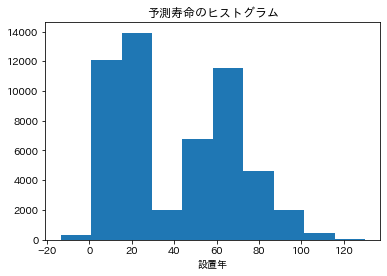

In [34]:
pd.DataFrame(pred).hist()

plt.title('予測寿命のヒストグラム')
plt.xlabel('設置年')
plt.grid()

plt.show() 

予測寿命と設置年から予測破損年を計算する

In [35]:
A['age'] = pd.DataFrame(pred.tolist()).astype(int)
A['install_year'] = A_install_year
A['break_year'] = A['install_year'] + A['age']

予測された破損年のヒストグラムを見てみます。

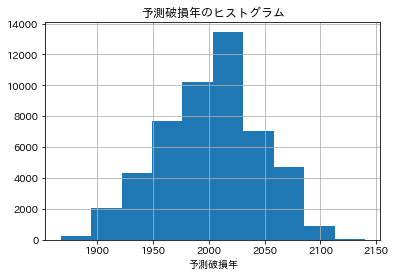

In [36]:
A['break_year'].hist()

plt.title('予測破損年のヒストグラム')
plt.xlabel('予測破損年')
plt.show()

<AxesSubplot:>

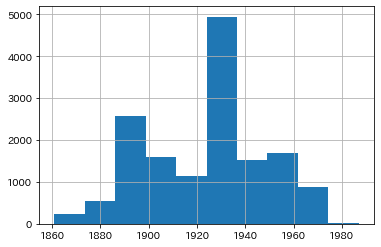

In [37]:
A[A['break_year'] < 1980]['install_year'].hist()

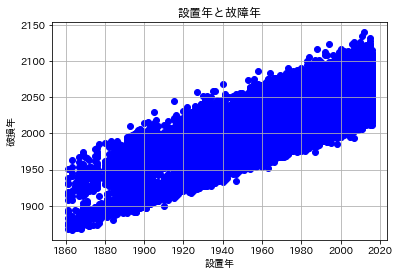

In [38]:
plt.scatter(A['install_year'], A['break_year'], color = 'blue')

plt.title('設置年と故障年')
plt.xlabel('設置年')
plt.ylabel('破損年')
plt.grid()

plt.show()  

### 2021年にパイプが破損する確率を求めたい
- S: 2020年には生きている（正常である）
- D: 2021年に死ぬ（破損する）

S, D が以上で与えられている時、求める確率は以下の通り

P(D|S) = P(D)/P(S)

In [39]:
def prob_break(A):

    p_s = (len(A) - len(A[A['break_year'] <= 2020])) / len(A) 
    display(p_s)

    p_d = len(A[A['break_year'] == 2021]) / len(A)
    display (p_d)

    p_2021 = p_d / p_s

    result = pd.DataFrame({'確率Probability of pipe break in 2021': p_2021},
                        index = ['Result'])

    return result    


display(prob_break(A))


0.3887935856796569

0.010460563117658027

,確率Probability of pipe break in 2021
Result,0.026905


2021年にパイプが破損する確率は約2.5％の予測になります。

### メトリックの作成

- 全予測データの内、負の年齢の確率を計測し、評価基準とする

- 予測において故障年は設置年よりも後に来る必要がある

- あるいは、パイプの年齢が負である事はありえない

- そうでない予測は誤りであるため、以上の評価基準を採用する

In [40]:
def my_metric(A):
    return 1 - len(A[A['age'] >= 0]) / len(A)

display(my_metric(A))

0.060954689539436835

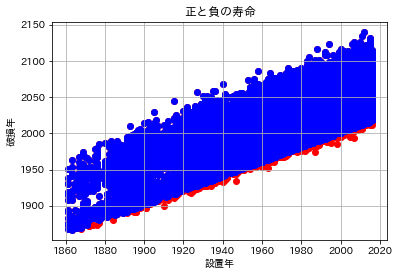

In [41]:
df_pos = A[A['break_year'] > A['install_year']] 

plt.scatter(A['install_year'], A['break_year'], color = 'red')
plt.scatter(df_pos['install_year'], df_pos['break_year'], color = 'blue')

plt.title('正と負の寿命')
plt.xlabel('設置年')
plt.ylabel('破損年')
plt.grid()

plt.show()  

### XGBoostを使用しモデル構築（モデルB）

In [42]:
X = df_break.drop(['age', 'pipe_id','break_year'], axis=1)
y = df_break['age']
A_install_year = df_alive['install_year']

In [43]:
# Create correlation matrix
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features 
X.drop(to_drop, axis=1, inplace=True)

In [44]:
X = df_break.drop(['age', 'pipe_id','break_year'], axis=1)
y = df_break['age']
A_install_year = df_alive['install_year']

drop_list = [
    # 'env_dat_31',
    # 'env_dat_40',
    # 'env_dat_48',
    # 'env_dat_80',
    # 'env_dat_99',
    # 'env_dat_123',
    # 'env_dat_126',
    # 'env_dat_127',
    # 'env_dat_27',
    # 'env_dat_45',
    # 'env_dat_49',
    # 'env_dat_51',
    # 'env_dat_77',    
    # 'env_dat_78',
    # 'env_dat_124',
    # 'env_dat_36',
    # 'env_dat_130', 
    # 'env_dat_55',
    # 'env_dat_118',
    # 'env_dat_35',
    # 'env_dat_76',
    # 'env_dat_28',
    # 'env_dat_52',
    # 'env_dat_56',
    # 'env_dat_125',
    # 'env_dat_75',
    # 'env_dat_79',
    # 'env_dat_128',
    # 'env_dat_46',
    # 'env_dat_37', 
    # 'env_dat_44', 
    # 'env_dat_58', 
    # 'env_dat_33', 
    # 'env_dat_43', 
    # 'env_dat_47', 
    # 'env_dat_50', 
    # 'env_dat_96', 
    # 'env_dat_84', 
    # 'env_dat_17', 
    # 'env_dat_90', 
    # 'env_dat_30', 
    # 'env_dat_83', 
    # 'env_dat_42', 
    # 'env_dat_53', 
    # 'env_dat_117', 
    # 'env_dat_91', 
    # 'env_dat_143', 
    # 'env_dat_85', 
    # 'env_dat_81', 
    # 'env_dat_100',  
    # 'env_dat_100',    
    'age', 
    'pipe_id',
    'break_year',
    'install_year',
    ]

X = df_break.drop(drop_list, axis=1).drop(to_drop, axis=1)
A = df_alive.drop(drop_list, axis=1).drop(to_drop, axis=1)

In [45]:
import xgboost as xgb
import optuna
from sklearn.metrics import mean_squared_error

optuna = False
if optuna:
    def objective(trial):
        # データを訓練用と検証用に分割する
        train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.33, random_state=42)

        # 1. パラメータと値の設定
        # 最適化したいパラメータと，パラメータがとる値の範囲を指定する
        params = {
            # "silent": 1,
            "max_depth": trial.suggest_int("max_depth", 3, 300),
            "min_child_weight": 1,
            "eta": trial.suggest_loguniform("eta", 0.01, 1.0),
            "tree_method": "exact",
            # "objective": "reg:linear",
            "eval_metric": "rmse",
            "predictor": "cpu_predictor",  
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_leaves": trial.suggest_int("max_leaves", 1, 300),
            "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        }

        # 2. モデルの訓練と評価
        # モデルの訓練
        model = xgb.XGBRegressor(**params)
        model.fit(train_X, train_y)

        # モデルの評価
        pred = model.predict(val_X)
        score = mean_squared_error(val_y, pred, squared=False)

        # 3. 目的関数の値を返す
        # 今回は回帰問題のためRMSEの値を最小化することを目的とする
        return score

    study = optuna.create_study(direction="minimize") 
    study.optimize(objective, 1, timeout=600)

    best_params = study.best_params
    print("  Params: ")
    for key, value in best_params.items():
        print("    {}: {}".format(key, value))

In [46]:
dtrain = xgb.DMatrix(X_train, y_train)
dvalid = xgb.DMatrix(X_test, y_test)

In [47]:
best_params = {
    # "silent": 1,
    # "n_estimators": 360,
    "max_depth": 7,
    "max_leaves":20,
    "learning_rate":0.015, 
    "min_child_weight": 1,
    "eta": 0.1,
    "tree_method": "exact",
    # "objective": "reg:linear",
    "eval_metric": "rmse",
    "predictor": "cpu_predictor"
}

model = xgb.train(params=best_params,
                  dtrain=dtrain,
                  num_boost_round=3000,
                  early_stopping_rounds=30,
                  evals= [(dtrain, "train"), (dvalid, "valid")]
)

[0]	train-rmse:61.89301	valid-rmse:62.60518
[1]	train-rmse:61.05336	valid-rmse:61.78634
[2]	train-rmse:60.22474	valid-rmse:60.98876
[3]	train-rmse:59.40951	valid-rmse:60.20645
[4]	train-rmse:58.60883	valid-rmse:59.42614
[5]	train-rmse:57.81885	valid-rmse:58.67946
[6]	train-rmse:57.04009	valid-rmse:57.93194
[7]	train-rmse:56.27676	valid-rmse:57.18926
[8]	train-rmse:55.52287	valid-rmse:56.47781
[9]	train-rmse:54.78328	valid-rmse:55.75919
[10]	train-rmse:54.05166	valid-rmse:55.06045
[11]	train-rmse:53.33227	valid-rmse:54.38125
[12]	train-rmse:52.62633	valid-rmse:53.69490
[13]	train-rmse:51.92970	valid-rmse:53.03533
[14]	train-rmse:51.24362	valid-rmse:52.38341
[15]	train-rmse:50.56919	valid-rmse:51.74269
[16]	train-rmse:49.90646	valid-rmse:51.10425
[17]	train-rmse:49.25364	valid-rmse:50.47633
[18]	train-rmse:48.60929	valid-rmse:49.86820
[19]	train-rmse:47.97479	valid-rmse:49.26793
[20]	train-rmse:47.35061	valid-rmse:48.67016
[21]	train-rmse:46.73953	valid-rmse:48.08402
[22]	train-rmse:46.1

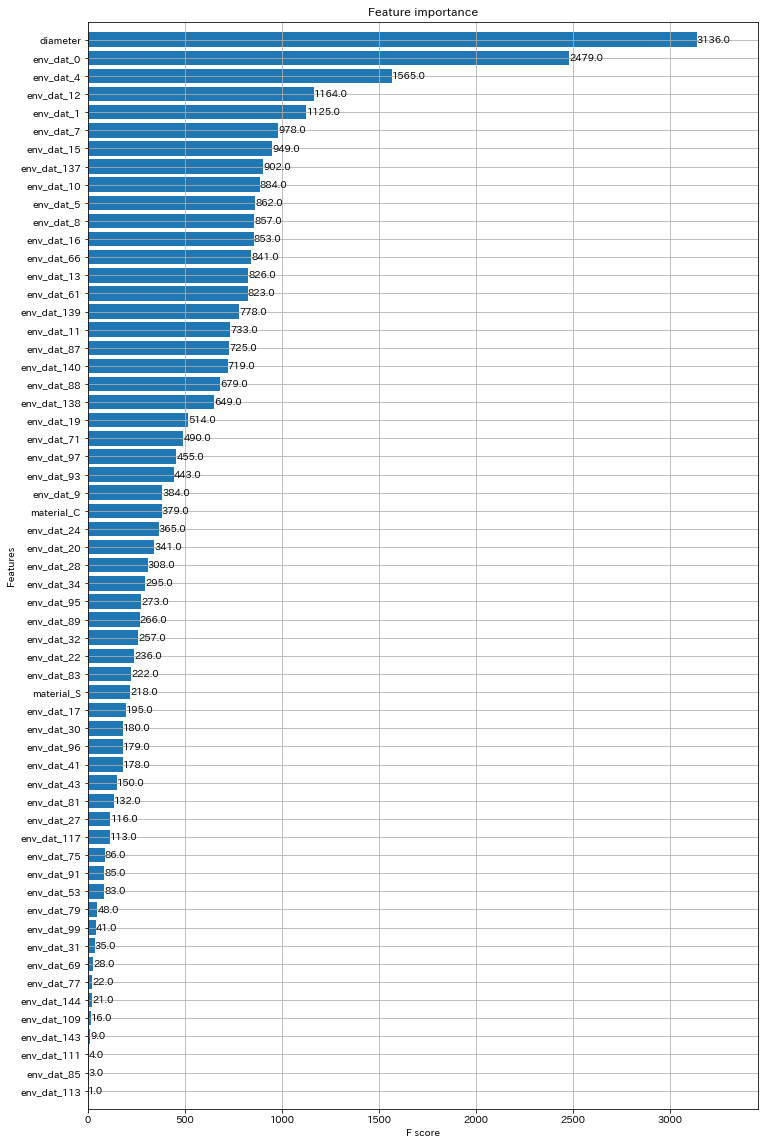

In [48]:
git, ax = plt.subplots(figsize=(12, 20))
xgb.plot_importance(model, max_num_features=120, height=0.8, ax=ax)
plt.show()

In [49]:
scores = calculate_scores(y_test, y_pred_test)
display(scores)

,R2,MAE,MSE,RMSE
scores,0.560285,14.375951,350.041735,18.709402


In [50]:
y_pred_train = model.predict(dtrain)
y_pred_test = model.predict(dvalid)

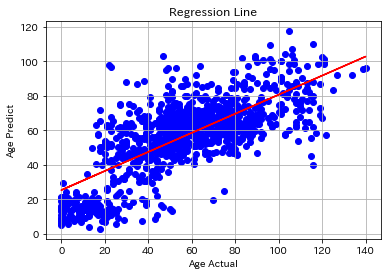

In [51]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

y_list_test = y_test.to_numpy()
lr.fit(y_list_test.reshape(-1, 1), y_pred_test)

plt.scatter(y_list_test, y_pred_test, color = 'blue')         # 説明変数と目的変数のデータ点の散布図をプロット
plt.plot(y_list_test, lr.predict(y_list_test.reshape(-1, 1)), color = 'red') # 回帰直線をプロット

plt.title('Regression Line')
plt.xlabel('Age Actual')
plt.ylabel('Age Predict')
plt.grid()

plt.show()

寿命を予測し、予測寿命と設置年から予測破損年を計算する

In [52]:
dA = xgb.DMatrix(A)
pred = model.predict(dA)

A['age'] = pd.DataFrame(pred.tolist()).astype(int)
A['install_year'] = A_install_year
A['break_year'] = A['install_year'] + A['age']

### XGBoostを使用した際の2021年における破損率の算出

In [53]:
display(prob_break(A))

0.3775871713593138

0.011392877121014357

,確率Probability of pipe break in 2021
Result,0.030173


In [54]:
display(my_metric(A))

0.058250978929703545

## 結論

lightGBMとXGBoostによって、それぞれモデルA、モデルBを作成した。

- 2021年における破損率
    * モデルA: 2.7%
    * モデルB: 3.0%

- 作成した評価指標
    * モデルA: 6.1%
    * モデルB: 5.8%

作成した評価指標を比較するとモデルBの方が精度が高く、その場合2021年における破損率は3.0%になった。